# Breast Cancer Classification with QML

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from qiskit import *
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import breast_cancer

In [61]:
# import data and show features/target
breast_cancer_data = load_breast_cancer()

df_breast_cancer = pd.DataFrame(breast_cancer_data.data, columns=breast_cancer_data.feature_names)
df_breast_cancer['target'] = pd.Series(breast_cancer_data.target)
print(df_breast_cancer.head())

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

In [59]:
# check for missing values
df_breast_cancer.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

In [62]:
# assign features and labels
X = breast_cancer_data.data
y = breast_cancer_data.target

In [94]:
# split into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

# normalise
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_valid = std_scale.transform(X_valid)

# reduce dimensions to num of qubits
n_dim = 4
pca = PCA(n_components=n_dim).fit(X_train)
X_train = pca.transform(X_train)
X_valid = pca.transform(X_valid)

# scale between -1 and +1
samples = np.append(X_train, X_valid, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
X_train = minmax_scale.transform(X_train)
X_valid = minmax_scale.transform(X_valid)

train_size = 100
X_train = X_train[:train_size]
y_train = y_train[:train_size]

test_size = 20
X_valid = X_valid[:test_size]
y_valid = y_valid[:test_size]

In [95]:
print(X_train[0], y_train[0])
print(X_valid[0], y_valid[0])

[-0.22911031 -0.42359258 -0.45997564 -0.18109929] 0
[-0.30470361 -0.0723116  -0.17691134 -0.41645614] 1


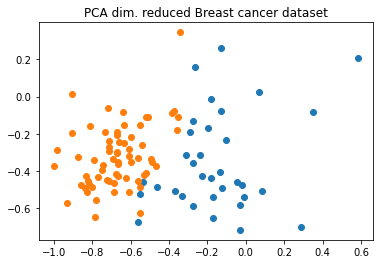

In [96]:
# plot pca reduced data as scatter
for i in range(0,2):
    plt.scatter(X_train[y_train == i, 0][:train_size],X_train[y_train == i, 1][:train_size])
    
plt.title("PCA dim. reduced Breast cancer dataset");

In [141]:
# assign ZZ feature map and kernel
zz_map = ZZFeatureMap(feature_dimension=4, reps=4, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

In [134]:
print(X_train[0])
print(X_train[1])

[-0.22911031 -0.42359258 -0.45997564 -0.18109929]
[-0.12559297 -0.4882461  -0.11631854 -0.6637592 ]


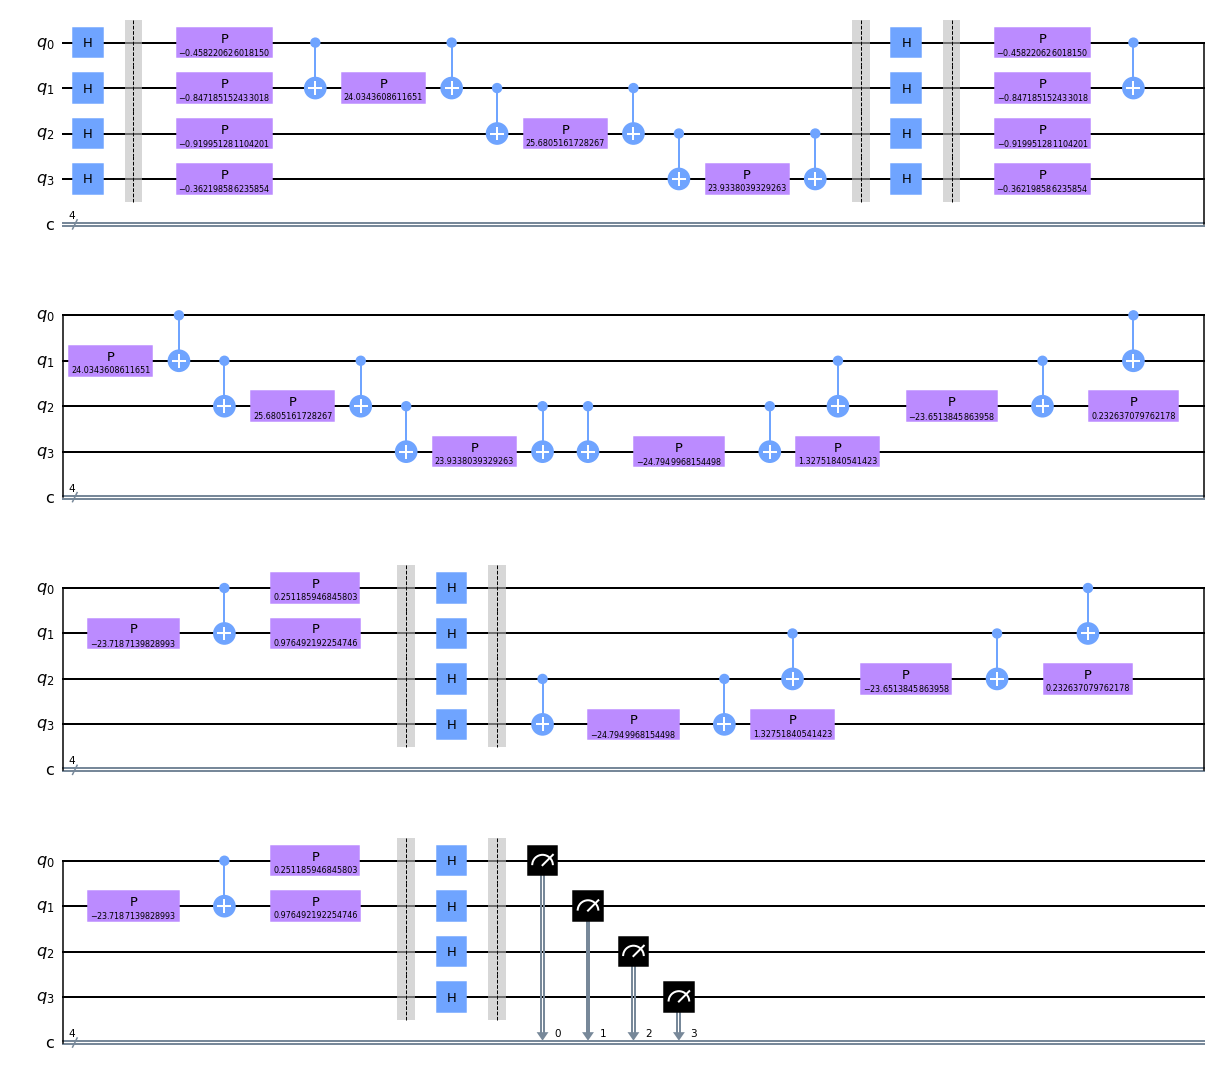

In [142]:
# plot example of encoded circuit
zz_circuit = zz_kernal.construct_circuit(X_train[0], X_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

In [136]:
# run circuit on qasm simulator to get counts
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, seed_simulator=1024, seed_transipiler=1024)
counts = job.result().get_counts(zz_circuit)

In [137]:
# get transition amplitude - proportion of counts in zero state
counts['0000']/sum(counts.values())

0.084228515625

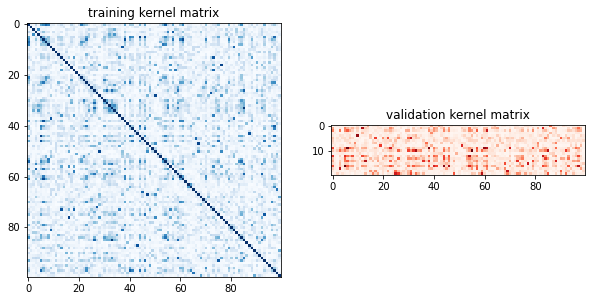

In [138]:
# evaluate all data into train and validation matrices and plot
matrix_train = zz_kernal.evaluate(x_vec=X_train)
matrix_valid = zz_kernal.evaluate(x_vec=X_valid, y_vec=X_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_valid),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("validation kernel matrix")
plt.show()

In [139]:
# use SVM with the quantum kernal matrices to classify
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, y_train)
zzpc_score = zzpc_svc.score(matrix_valid, y_valid)

print(f'Precomputed kernel classification test score: {zzpc_score}')

Precomputed kernel classification test score: 0.75


In [140]:
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(X_train, y_train)
zzcb_score = zzcb_svc.score(X_valid, y_valid)

print(f'Callable kernel classification test score: {zzcb_score}')

Callable kernel classification test score: 0.75


In [130]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(X_train, y_train)
    classical_score = classical_svc.score(X_valid, y_valid)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))

linear kernel classification test score:  0.90
poly kernel classification test score:  0.95
rbf kernel classification test score:  0.95
sigmoid kernel classification test score:  0.50
